In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

### Old Boiler Inspections

In [3]:
df = pd.read_csv('data/bis_boiler_final.csv')
df.head()

,ENTRYDATE,INSP-DATE,Int/Ext,NAME,NYSCERTIFICATE,REC-DATE,RESULTS,bin_number,boiler_id
0,05/31/2016,10/23/2015,NaN,TRAVELERS INSURANCE CO,3012,10/30/2015,DEFECTS CORRECTED,1059945.0,10000008199Y0001
1,03/10/2016,02/04/2016,NaN,THE HARTFORD STEAM BLR INSP INS,5240,03/08/2016,NO DEFECTS,1059945.0,10000008199Y0001
2,09/22/2015,07/21/2015,NaN,TRAVELERS INSURANCE CO,5499,08/13/2015,DEFECTS EXIST,1059945.0,10000008199Y0001
3,12/24/2014,09/18/2014,NaN,TRAVELERS INSURANCE CO,3012,10/01/2014,NO DEFECTS,1059945.0,10000008199Y0001
4,04/11/2013,03/13/2013,NaN,TRAVELERS INSURANCE CO,3012,03/27/2013,NO DEFECTS,1059945.0,10000008199Y0001


In [4]:
df.shape

(1930647, 9)

In [5]:
df.boiler_id.nunique()

95708

In [6]:
date_fmt = '%m/%d/%Y'
for col in ['ENTRYDATE','INSP-DATE','REC-DATE']:
    df[col] = pd.to_datetime(df[col], errors='coerce', format=date_fmt)

In [7]:
df.isnull().sum()

ENTRYDATE          171629
INSP-DATE            3214
Int/Ext           1741883
NAME                 2720
NYSCERTIFICATE     171627
REC-DATE           251203
RESULTS            171636
bin_number           1448
boiler_id               0
dtype: int64

In [8]:
df[df['INSP-DATE'].isnull()].head()

,ENTRYDATE,INSP-DATE,Int/Ext,NAME,NYSCERTIFICATE,REC-DATE,RESULTS,bin_number,boiler_id
3694,NaT,NaT,V#32051675R,NaN,NaN,NaT,NaN,1041857.0,10000045096Y0001
4764,NaT,NaT,V#32056489X/HT STORE,NaN,NaN,NaT,NaN,3038707.0,30000114129N0001
6905,1999-03-04,NaT,NaN,LOSQUADRO ANTHONY,O 4247,NaT,NO DEFECTS,3031852.0,30000070334Y0001
7863,NaT,NaT,BLR NOT REGISTERED,NaN,NaN,NaT,NaN,1078847.0,10000078298Y0002
8468,NaT,NaT,110362937,NaN,NaN,NaT,NaN,1026694.0,10000088304N0001


In [9]:
df[df['ENTRYDATE'].isnull()].head()

,ENTRYDATE,INSP-DATE,Int/Ext,NAME,NYSCERTIFICATE,REC-DATE,RESULTS,bin_number,boiler_id
24,NaT,1999-06-30,INSURANCE CANCELLED,HARTFORD STEAM,NaN,NaT,NaN,1059945.0,10000008199Y0001
82,NaT,2008-11-12,F/T PASSED 110241827,ANTZ 2316 (GM),NaN,NaT,NaN,1016116.0,10000017652Y0001
83,NaT,2008-10-21,FAILED F/T 110241827,ANTZ 2316 (GM),NaN,NaT,NaN,1016116.0,10000017652Y0001
103,NaT,2018-04-27,FAILED F/T 122323262,ORTIZ ALGUER 2867,NaN,NaT,NaN,1006432.0,10000018251Y0001
104,NaT,2018-02-07,FAILED F/T 122323262,HAFFEY KEVIN 2731,NaN,NaT,NaN,1006432.0,10000018251Y0001


Some rows seem to be annotations instead of actual inspections, droping those.

In [10]:
df_clean = df.loc[~df['INSP-DATE'].isnull() & ~df['ENTRYDATE'].isnull() & ~df['RESULTS'].isnull()].copy()
df_clean.isnull().sum()

ENTRYDATE               0
INSP-DATE               0
Int/Ext           1741067
NAME                  123
NYSCERTIFICATE          0
REC-DATE            79446
RESULTS                 0
bin_number              0
boiler_id               0
dtype: int64

In [11]:
df_clean.boiler_id.nunique()

90304

~5k boilers with no data.

In [12]:
df_clean['INSP-DATE'].sort_values().head()

1517375   1905-09-19
352915    1908-05-01
1177039   1966-06-18
834667    1991-01-31
593825    1991-04-21
Name: INSP-DATE, dtype: datetime64[ns]

In [13]:
df_clean.RESULTS.value_counts()

NO DEFECTS                   1533246
DEFECTS EXIST                 195699
DEFECTS CORRECTED              21791
NO DEFECTS - LATE FILING        4605
DEFECTS CORRECTED - LATE        2697
DEFECTS EXIST - LATE FILI        490
EXTENSION GRANTED                 69
4 - UNKNOWN                       10
y - UNKNOWN                       10
5 - UNKNOWN                        2
7 - UNKNOWN                        1
n - UNKNOWN                        1
I - UNKNOWN                        1
Name: RESULTS, dtype: int64

In [14]:
def defects_exist(series):
    return int(any('DEFECTS EXIST' in result for result in series))

In [15]:
df_clean.loc[:,'inspection_year'] = df_clean['INSP-DATE'].dt.year

#Group by boiler_id and year, get dummy if defects existed in each year
bis_boiler_year = df_clean.groupby(['boiler_id', 'inspection_year'])\
                            .agg({'RESULTS': defects_exist, 'bin_number': min})\
                            .rename(columns={'RESULTS':'defects_exist'})
bis_boiler_year.reset_index(inplace = True)

#Bin number to int
bis_boiler_year['bin_number'] = bis_boiler_year['bin_number'].astype(int, errors='coerce')

bis_boiler_year.head()

,boiler_id,inspection_year,bin_number,defects_exist
0,10000000027N0001,1993,1080776,0
1,10000000027N0001,1994,1080776,0
2,10000000027N0001,1995,1080776,0
3,10000000027N0001,1996,1080776,0
4,10000000027N0001,1997,1080776,0


### DOB Now Boiler Inspections

In [16]:
dob_now = pd.read_csv('data/DOB_NOW__Safety_Boiler.csv', parse_dates=[-8], infer_datetime_format=True)
dob_now.head()

,Tracking Number,Boiler ID,Report Type,ApplicantFirst Name,Applicant Last Name,Applicant License Type,Applicant License Number,Owner First Name,Owner Last Name,Boiler Make,...,Pressure Type,Inspection Type,Inspection Date,Defects Exist,LFF (45 Days),LFF (180 Days),Filing Fee,Total Amount Paid,Report Status,Bin Number
0,2017-10000008199Y0001-24915,10000008199Y0001,Initial,DREW,THOMAS,BB,5468.0,BARBARA,KAMMERER,ROCKMILLS STE,...,Low Pressure,External,2017-11-17,No,0,0,30,30,Accepted,1059945
1,2017-10000017650Y0001-24577,10000017650Y0001,Initial,BENJAMIN,WAGNER,BB,5469.0,LINDA,BALIDEMAJ,ROCKMILLS,...,Low Pressure,External,2017-11-15,No,0,0,30,30,Accepted,1017834
2,2017-10000017652Y0001-24652,10000017652Y0001,Initial,JOHN,KNIEF,O,5317.0,CHRISTINA,RIVERA,H.B. SMITH,...,Low Pressure,External,2017-11-14,No,0,0,30,30,Accepted,1016116
3,2017-10000018251Y0001-24562,10000018251Y0001,Initial,BENJAMIN,WAGNER,BB,5469.0,NATE,KLEIN,PEERLESS,...,Low Pressure,External,2017-11-15,No,0,0,30,30,Accepted,1006432
4,2017-10000018279Y0001-24631,10000018279Y0001,Initial,EDWIN,VAZQUEZ,P,1526.0,LEONARD,EIS,CROTTY,...,Low Pressure,External,2017-11-17,No,0,0,30,30,Accepted,1006285


In [17]:
dob_now['Defects Exist'].value_counts()

No     154457
Yes     13704
Name: Defects Exist, dtype: int64

In [18]:
def defects_exist_dnow(series):
    return int('Yes' in series.values)

In [19]:
dob_now.loc[:,'inspection_year'] = dob_now['Inspection Date'].dt.year

#Group by boiler_id and year, get dummy for if defects existed in each year
dnow_boiler_year = dob_now.groupby(['Boiler ID', 'inspection_year'])\
                            .agg({'Defects Exist': defects_exist_dnow, 'Bin Number': min})

dnow_boiler_year.reset_index(inplace = True)

dnow_boiler_year.rename(columns={'Boiler ID':'boiler_id',
                                     'Defects Exist':'defects_exist',
                                     'Bin Number': 'bin_number'},
                            inplace=True)

#Bin number to int
dnow_boiler_year['bin_number'] = dnow_boiler_year['bin_number'].astype(int, errors='coerce')

#Drop bad boiler ids
dnow_boiler_year = dnow_boiler_year.loc[(dnow_boiler_year.boiler_id.apply(lambda x: str(x)[0].isdigit()))
                                               & (dnow_boiler_year.boiler_id.apply(lambda x: str(x)[1:11].isdigit()))
                                               & (dnow_boiler_year.boiler_id.apply(lambda x: str(x)[12:].isdigit()))].copy()
dnow_boiler_year = dnow_boiler_year.loc[dnow_boiler_year.boiler_id.apply(lambda x: int(x[0]) > 0)].copy()

dnow_boiler_year.head()

,boiler_id,inspection_year,bin_number,defects_exist
6,10000000000N0000,2017,1059499,0
7,10000000000N0000,2018,1082350,0
8,10000000000N0001,2017,1005806,0
9,10000000000N0002,2017,1005806,0
10,10000000000Y0000,2017,1057373,0


In [20]:
dnow_boiler_year.boiler_id.nunique()

95708

## Join and get stats

Have to decide what to do with boilers where there is no data on the old system. We could drop them or assume they where installed in 2017.

**Dropping for now as we need to check on the historical website what's going on with the ones we couldn't get.**

In [21]:
dnow_boiler_year = dnow_boiler_year.loc[dnow_boiler_year.boiler_id.isin(bis_boiler_year.boiler_id)].copy()

In [22]:
all_boiler_year = pd.concat([bis_boiler_year, dnow_boiler_year], ignore_index=True)
all_boiler_year.sort_values(['boiler_id', 'inspection_year'], inplace=True)
all_boiler_year.reset_index(drop=True, inplace=True)
all_boiler_year.head()

,boiler_id,inspection_year,bin_number,defects_exist
0,10000000027N0001,1993,1080776,0
1,10000000027N0001,1994,1080776,0
2,10000000027N0001,1995,1080776,0
3,10000000027N0001,1996,1080776,0
4,10000000027N0001,1997,1080776,0


In [23]:
all_boiler_year.inspection_year.value_counts()

2017    88798
2018    85329
2015    80262
2016    79398
2014    78146
2013    75300
2011    70229
2009    69209
2010    68919
2008    67502
2007    66596
2006    65434
2005    64594
2004    62993
2012    62284
2003    60727
2002    59805
2001    57637
2000    55715
1999    55385
1998    53842
1997    51052
1996    50053
1995    46103
1994    44133
1993    43116
1992    36392
2019    27424
1991       29
1900       19
1966        1
1908        1
1905        1
2207        1
2099        1
Name: inspection_year, dtype: int64

In [24]:
#Remove bad years
all_boiler_year = all_boiler_year.loc[(all_boiler_year.inspection_year > 1991) & (all_boiler_year.inspection_year <= 2019)].copy()

In [25]:
#First inspection for each boiler
boiler_first_insp = all_boiler_year.groupby('boiler_id')['inspection_year'].min()
boiler_first_insp.head()

boiler_id
10000000027N0001    1993
10000000027N0002    1993
10000000027N0003    2009
10000000027N0004    2009
10000000027N0005    2009
Name: inspection_year, dtype: int64

In [26]:
#Add year of first inspection
all_boiler_year['first_inspection'] = all_boiler_year['boiler_id'].apply(lambda x: boiler_first_insp[x])
#Calculate boiler age (years from first inspection)
all_boiler_year['boiler_age'] = all_boiler_year.apply(lambda x: int(x['inspection_year'] - x['first_inspection']), axis=1)

all_boiler_year.head()

,boiler_id,inspection_year,bin_number,defects_exist,first_inspection,boiler_age
0,10000000027N0001,1993,1080776,0,1993,0
1,10000000027N0001,1994,1080776,0,1993,1
2,10000000027N0001,1995,1080776,0,1993,2
3,10000000027N0001,1996,1080776,0,1993,3
4,10000000027N0001,1997,1080776,0,1993,4


In [27]:
#Mark change of boiler id
all_boiler_year['boiler_change'] = (all_boiler_year.boiler_id.shift(-1) != all_boiler_year.boiler_id).apply(lambda x: -1 if x else None)

#Add year if there is defects
all_boiler_year['years_since_last_defects'] = all_boiler_year.apply(
    lambda x: x['inspection_year'] if (x['defects_exist'] == 1) & (x['boiler_change'] != -1) else x['boiler_change'], axis=1).shift(1)

#Drop change of boiler id
all_boiler_year.drop('boiler_change', axis=1, inplace=True)

#Front fill
all_boiler_year.years_since_last_defects.fillna(method='ffill', inplace=True)

#Replace -1 to NaN (No defects found before)
all_boiler_year.years_since_last_defects.replace(-1, np.nan, inplace=True)

#Get time in years
all_boiler_year.years_since_last_defects = all_boiler_year.inspection_year - all_boiler_year.years_since_last_defects

all_boiler_year.head(30)

,boiler_id,inspection_year,bin_number,defects_exist,first_inspection,boiler_age,years_since_last_defects
0,10000000027N0001,1993,1080776,0,1993,0,NaN
1,10000000027N0001,1994,1080776,0,1993,1,NaN
2,10000000027N0001,1995,1080776,0,1993,2,NaN
3,10000000027N0001,1996,1080776,0,1993,3,NaN
4,10000000027N0001,1997,1080776,0,1993,4,NaN
5,10000000027N0001,1998,1080776,0,1993,5,NaN
6,10000000027N0001,2000,1080776,0,1993,7,NaN
7,10000000027N0001,2002,1080776,0,1993,9,NaN
8,10000000027N0001,2003,1080776,0,1993,10,NaN
9,10000000027N0001,2004,1080776,0,1993,11,NaN


### Add DOB Now Boiler Data

In [28]:
dob_now.columns

Index(['Tracking Number', 'Boiler ID', 'Report Type', 'ApplicantFirst Name',
       'Applicant Last Name', 'Applicant License Type',
       'Applicant License Number', 'Owner First Name', 'Owner Last Name',
       'Boiler Make', 'Boiler Model', 'Pressure Type', 'Inspection Type',
       'Inspection Date', 'Defects Exist', 'LFF (45 Days)', 'LFF (180 Days)',
       'Filing Fee', 'Total Amount Paid', 'Report Status', 'Bin Number',
       'inspection_year'],
      dtype='object')

In [29]:
dob_now_boiler_data = dob_now.groupby('Boiler ID')['Boiler Make', 'Boiler Model', 'Pressure Type'].min()
dob_now_boiler_data.head()

,Boiler Make,Boiler Model,Pressure Type
Boiler ID,,,
0000000000000000,Slant Fin,EG-75,Low Pressure
000000000BNR0000,Slant Fin,GG375,Low Pressure
0000000016492301,BURNHAM,5008N,Low Pressure
00000000BNRN0000,Slant Fin,GG375,Low Pressure
00000000BNRN0003,AO SMITH,HW-670,Low Pressure


In [30]:
all_boiler_year[['boiler_make', 'boiler_model', 'boiler_pressure_type']] = all_boiler_year['boiler_id'].apply(
    lambda x: dob_now_boiler_data.loc[x])
all_boiler_year.head()

,boiler_id,inspection_year,bin_number,defects_exist,first_inspection,boiler_age,years_since_last_defects,boiler_make,boiler_model,boiler_pressure_type
0,10000000027N0001,1993,1080776,0,1993,0,NaN,SLANTFIN,GG-399,Low Pressure
1,10000000027N0001,1994,1080776,0,1993,1,NaN,SLANTFIN,GG-399,Low Pressure
2,10000000027N0001,1995,1080776,0,1993,2,NaN,SLANTFIN,GG-399,Low Pressure
3,10000000027N0001,1996,1080776,0,1993,3,NaN,SLANTFIN,GG-399,Low Pressure
4,10000000027N0001,1997,1080776,0,1993,4,NaN,SLANTFIN,GG-399,Low Pressure


In [344]:
all_boiler_year.to_csv('data/all_boiler_year_data.csv', index=False)

### Check the data

In [31]:
all_boiler_year.columns

Index(['boiler_id', 'inspection_year', 'bin_number', 'defects_exist',
       'first_inspection', 'boiler_age', 'years_since_last_defects',
       'boiler_make', 'boiler_model', 'boiler_pressure_type'],
      dtype='object')

In [32]:
all_boiler_year.shape

(1726377, 10)

In [33]:
all_boiler_year.boiler_id.nunique()

90304

In [34]:
#Average years per boiler in the data
len(all_boiler_year)/all_boiler_year.boiler_id.nunique()

19.117392363571934

In [35]:
#Percentage of times defects are found
all_boiler_year.defects_exist.value_counts()/len(all_boiler_year)*100

0    88.279095
1    11.720905
Name: defects_exist, dtype: float64

In [36]:
all_boiler_year.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,inspection_year,bin_number,defects_exist,first_inspection,boiler_age,years_since_last_defects
count,1.726377e+06,1.726377e+06,1.726377e+06,1.726377e+06,1.726377e+06,684814.000000
mean,2.006762e+03,2.598319e+06,1.172090e-01,1.994959e+03,1.180362e+01,4.616589
std,7.715736e+00,1.247971e+06,3.216693e-01,5.356786e+00,7.723902e+00,3.861418
min,1.992000e+03,1.000008e+06,0.000000e+00,1.992000e+03,0.000000e+00,0.000000
25%,2.000000e+03,1.062925e+06,0.000000e+00,1.992000e+03,5.000000e+00,NaN
50%,2.007000e+03,3.032887e+06,0.000000e+00,1.992000e+03,1.100000e+01,NaN
75%,2.014000e+03,3.343114e+06,0.000000e+00,1.995000e+03,1.800000e+01,NaN
max,2.019000e+03,5.863593e+06,1.000000e+00,2.017000e+03,2.700000e+01,27.000000


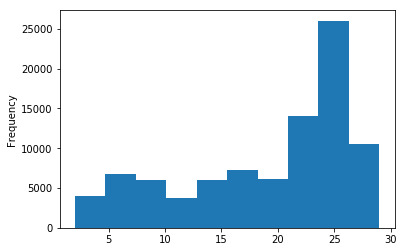

In [37]:
all_boiler_year.groupby('boiler_id')['inspection_year'].count().plot.hist()

In [41]:
all_boiler_year.years_since_last_defects.value_counts()

1.0     176222
2.0      96652
3.0      73997
4.0      61461
5.0      50639
6.0      43309
7.0      37997
8.0      32922
9.0      28006
10.0     22170
11.0     16878
12.0     12505
13.0      9308
14.0      6850
15.0      4718
16.0      3099
17.0      1834
0.0       1217
18.0      1171
19.0       880
20.0       710
21.0       609
22.0       506
23.0       412
24.0       312
25.0       249
26.0       163
27.0        18
Name: years_since_last_defects, dtype: int64

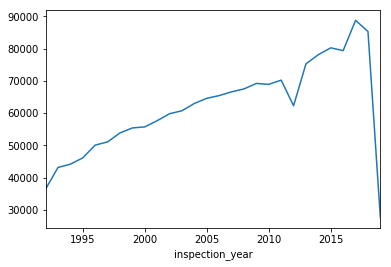

In [38]:
all_boiler_year.groupby('inspection_year')['boiler_id'].count().plot()

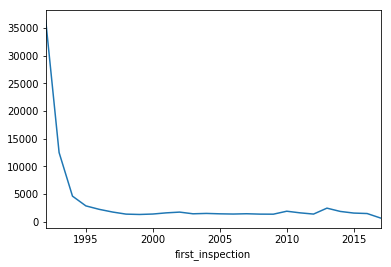

In [39]:
all_boiler_year.drop_duplicates('boiler_id').groupby('first_inspection')['boiler_id'].count().plot()

In [45]:
all_boiler_year.years_since_last_defects.value_counts()

1.0     176222
2.0      96652
3.0      73997
4.0      61461
5.0      50639
6.0      43309
7.0      37997
8.0      32922
9.0      28006
10.0     22170
11.0     16878
12.0     12505
13.0      9308
14.0      6850
15.0      4718
16.0      3099
17.0      1834
0.0       1217
18.0      1171
19.0       880
20.0       710
21.0       609
22.0       506
23.0       412
24.0       312
25.0       249
26.0       163
27.0        18
Name: years_since_last_defects, dtype: int64

In [46]:
all_boiler_year.groupby('years_since_last_defects')['defects_exist'].mean()

years_since_last_defects
0.0     0.986031
1.0     0.457179
2.0     0.214812
3.0     0.140316
4.0     0.119067
5.0     0.103122
6.0     0.091644
7.0     0.078322
8.0     0.073507
9.0     0.068985
10.0    0.067524
11.0    0.065885
12.0    0.067573
13.0    0.060700
14.0    0.055036
15.0    0.059983
16.0    0.050984
17.0    0.060523
18.0    0.046114
19.0    0.062500
20.0    0.040845
21.0    0.057471
22.0    0.049407
23.0    0.048544
24.0    0.044872
25.0    0.068273
26.0    0.085890
27.0    0.000000
Name: defects_exist, dtype: float64